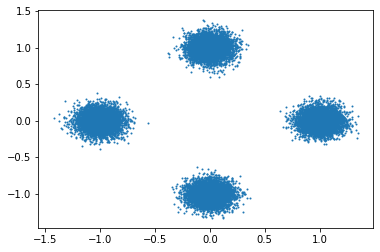

In [144]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import random
import torch.nn.init as init
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_group, n_data):

        self.n_group = n_group
        self.n_data = n_data
        _data = np.random.randn(self.n_data, 2)
        _label = np.ndarray(self.n_data, dtype=np.int)
        _mu = []
        _sig = 0.1
        for k in range(n_group):
            _mu.append([np.cos(2.0 * np.pi * k / n_group), np.sin(2.0 * np.pi * k / n_group)])
        for i in range(n_data):
            _data[i][0] = _sig * _data[i][0] + _mu[i % n_group][0]
            _data[i][1] = _sig * _data[i][1] + _mu[i % n_group][1]
            _label[i] = i % n_group

        self.data = torch.as_tensor(_data, dtype=torch.float32)
        self.label = torch.as_tensor(_label, dtype=torch.int64)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        # return self.data[idx], self.label[idx]
        return self.data[idx]


data_size = 20000
dataset = CustomDataSet(n_group=4, n_data=data_size)

data_points = dataset.data.numpy()
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()

In [145]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if device == 'cuda': 
    torch.cuda.manual_seed_all(777)
print(device)

cpu


In [146]:
X = dataset.data

In [147]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=3, bias=True),
            torch.nn.Softmax(dim=1)
        ).to(device)

    def forward(self, x):
        return self.layer(x)


def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


In [148]:
discriminator = Discriminator()
d_solver = optim.Adam(discriminator.parameters(), lr=0.0001, weight_decay=0.00001)

In [149]:
MI = []
num_epochs = 10000
for epoch in range(num_epochs):
    d_solver.zero_grad()
    Y = discriminator(X)
    marginal_Y = torch.mean(Y, dim=0)
    H_Y_GIVEN_X = torch.mean(torch.sum(-Y * torch.log(Y), dim=1))
    H_Y = torch.sum(-marginal_Y * torch.log(marginal_Y))
    MUTUAL_INFOMATION = H_Y - H_Y_GIVEN_X
    (-MUTUAL_INFOMATION).backward()
    d_solver.step()
    MI.append(MUTUAL_INFOMATION)

In [150]:
print(marginal_Y)

tensor([0.5000, 0.2500, 0.2500], grad_fn=<MeanBackward1>)


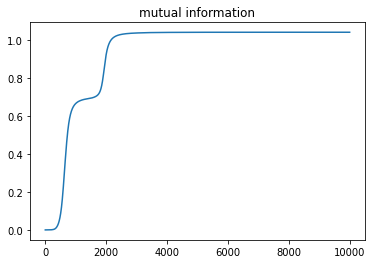

In [151]:
plt.title('mutual information')
plt.plot(np.arange(1, len(MI) + 1), MI)
plt.show()

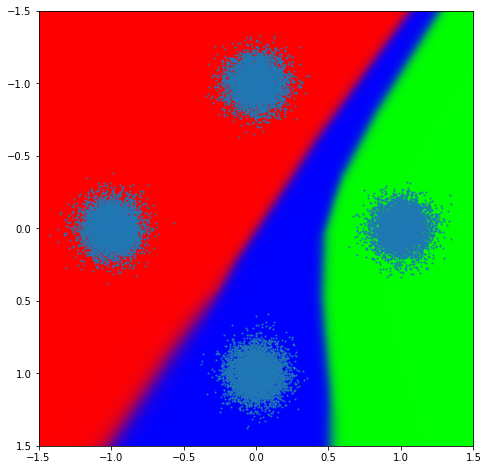

In [152]:
resol = 500
left_point = -1.5
right_point = 1.5
offset = (right_point - (left_point))/resol 

p = np.ones((resol, resol, 3), np.float64)


x_region = torch.zeros((resol, resol, 2), dtype=torch.float)
for a_step in range(resol):
    for b_step in range(resol):
        x_region.data[a_step][b_step][0] = left_point + offset * (a_step)
        x_region.data[a_step][b_step][1] = left_point + offset * (b_step)

y = discriminator(x_region.reshape(-1, 2)).reshape(resol, resol, 3)
for a_step in range(resol):
    for b_step in range(resol):
        p[b_step][a_step][0] = y[b_step][a_step][0]
        p[b_step][a_step][1] = y[b_step][a_step][1]
        p[b_step][a_step][2] = y[b_step][a_step][2]

plt.figure(figsize=(8,8))

plt.imshow(p, interpolation='spline36', extent=[left_point, right_point, right_point, left_point])  #first dim = y axis,  second dim = x axis
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()